# BRAIN TUMOR SEGMENTATION
Data available at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

## 0. libraries

In [1]:
import tensorflow_io as tfio
import numpy as np 
import pandas as pd 
import PIL
import glob
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('dark_background')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Example-Label pairing

Identify examples and labels

In [4]:
# get the images file paths
filenames = []
for path, currentDirectory, files in os.walk("lgg-mri-segmentation"):
    for file in files:
        if file.endswith('.tif'):
            filenames.append(path + '/' + file)
filenames = sorted(filenames)

original = []
mask = []
for image in filenames:
    if image.endswith('mask.tif'):
        mask.append(image)
    else:
        original.append(image)

mask = sorted(mask, key = len)
original = sorted(original, key = len)
data = pd.DataFrame({'original': original, 'mask':mask})
data.head(10)

nSamples = len(original)
print('dataset features a total of: ',nSamples,' labelled examples')

dataset features a total of:  3929  labelled examples


Load and show a train example

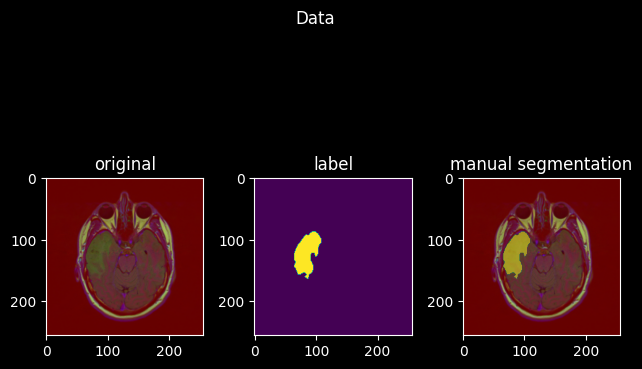

In [5]:
idx = np.random.randint(0,nSamples-1)
img = PIL.Image.open(data['original'][idx])
lbl = PIL.Image.open(data['mask'][idx])

fig, axs = plt.subplots(1,3)
axs[0].imshow(img), axs[0].set_title('original')
axs[1].imshow(lbl), axs[1].set_title('label')
axs[2].imshow(img), axs[2].set_title('manual segmentation')
axs[2].imshow(lbl, alpha=0.5 * (np.array(lbl) > 0))
fig.suptitle('Data')
fig.tight_layout()
plt.show()

In [6]:
img_size = np.array(img).shape[:2]
img_shape= np.array(img).shape

print('each example has dimension: ', img_size)
print('each array has shape:    ', img_shape)

each example has dimension:  (256, 256)
each array has shape:     (256, 256, 3)


## 2. Dataset creation

train - val splitting

In [7]:
x_train, x_test = train_test_split(data, test_size = 0.2, shuffle=True)

Data loading and preprocessing using Image Generators

In [8]:
BATCHSIZE = 16
def preprocess(img, mask):
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_gen(x):
    gen = ImageDataGenerator(
        rescale=1./255
    )

    img_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='original',
                                      class_mode=None, 
                                      target_size=img_size,
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    
    mask_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='mask',
                                      class_mode=None, 
                                      target_size=img_size,
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    generator = zip(img_gen, mask_gen)
    
    for (img, mask) in generator:
        img, mask = preprocess(img, mask)
        yield (img, mask)

train = create_gen(x_train)
val = create_gen(x_test)

## 3. Model creation
4 layers U-Net

In [9]:
img_input = layers.Input(img_shape)

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = layers.BatchNormalization()(x)
block_1_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_1_out)

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = layers.BatchNormalization()(x)
block_2_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_2_out)

# Block 3
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = layers.BatchNormalization()(x)
block_3_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_3_out)

# Block 4
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = layers.BatchNormalization()(x)
block_4_out = layers.Activation('relu')(x)

# UP 1
x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_3_out])
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 2
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_2_out])
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 3
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_1_out])
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(img_input, x)
model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy')

e:\Data\documenti\PROGRAMMAZIONE\Segmentation\autoencoders\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

## 4. Model training

In [10]:
history = model.fit(train, 
          epochs=100, 
          validation_data= val,
          steps_per_epoch= len(x_train)// BATCHSIZE,
          validation_steps= len(x_test) // BATCHSIZE,
          verbose=1
          )

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100
196/196 [==============================] - ETA: 0s - loss: 0.0430Found 786 validated image filenames.
Found 786 validated image filenames.
196/196 [==============================] - 94s 392ms/step - loss: 0.0430 - val_loss: 0.0512
Epoch 2/100
196/196 [==============================] - 83s 394ms/step - loss: 0.0305 - val_loss: 0.0370
Epoch 3/100
196/196 [==============================] - 77s 394ms/step - loss: 0.0269 - val_loss: 0.1011
Epoch 4/100
196/196 [==============================] - 77s 394ms/step - loss: 0.0216 - val_loss: 0.2333
Epoch 5/100
196/196 [==============================] - 77s 394ms/step - loss: 0.0190 - val_loss: 0.0531
Epoch 6/100
196/196 [==============================] - 77s 395ms/step - loss: 0.0170 - val_loss: 0.0190
Epoch 7/100
196/196 [==============================] - 77s 394ms/step - loss: 0.0156 - val_loss: 0.0232
Epoch 8/100
196/196 [==============================] - 77

## 5. Evaluation

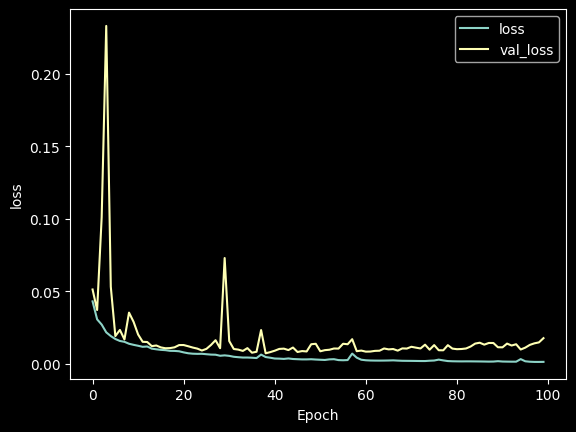

In [38]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

Save outputs

In [53]:
if not(os.path.exists('model_output')):
    os.mkdir('model_output')

nSaveImages = 50
for im in range(nSaveImages):
    rows = 3
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize = (60, 60))    

    for i in range(rows):

        idx = np.random.randint(0,nSamples-1)
        img = PIL.Image.open(data['original'][idx])
        lbl = PIL.Image.open(data['mask'][idx])
        
        
        pred = model.predict(np.expand_dims(np.array(img)/255,0))
        
        axs[i,0].imshow(img), axs[i,0].set_title('original',fontsize=50)
        axs[i,1].imshow(lbl), axs[i,1].set_title('label',fontsize=50)

        axs[i,2].imshow(img), axs[i,2].set_title('automatic segmentation', fontsize=50)
        axs[i,2].imshow(pred[0], alpha=((pred[0] > 0.1) * 0.5)[:,:,0])

        axs[i,3].imshow(pred[0], cmap='gray'), axs[i,3].set_title('predicted',fontsize=50)
    fig.suptitle('MODEL EVALUATION',fontsize=50)
    import uuid
    figname = uuid.uuid1()
    fig.savefig('model_output/'+str(figname))
    plt.close()

1/1 [==============================] - 0s 17ms/step
